Let $s$ be a sequence of i.i.d. unbiased coin flips (heads are 1, tails are 0), represented as series $I(t)$ of input pulses with pulse width 1 when $s_m = 1$. Given a 1-D linear system with timescale $\tau$ we want to figure out response distribution $P(r)$ given response resolution $1/\Delta r$, where 

$$r = \int_0^\infty \frac{1}{\tau}\exp(-t/\tau) I(-t) dt$$

and where $t=0$ aligns with the pulse boundary (i.e. so $t=0$ is never in the middle of a pulse).

We want to calculate the probability that $r$ lands in the nth bin of size $\Delta r$ where the number of bins is $N = 1/\Delta r$. 

Note $0 \leq r \leq 1$, $n \in \{0, 1, ..., N-1\}$.

We have $$P(r \textrm{ in nth bin}) = P(n\Delta r \leq r < (n+1)\Delta r) = 1 - P(r < n\Delta r) - P(r \geq (n+1)\Delta r)$$

If the mth symbol, whose pulse spans time $m$ and $m+1$, is 1, it contributes

$$r_m = \int_m^{m+1} \frac{1}{\tau} \exp(-t/\tau) dt = -[\exp(-(m+1)/\tau) - \exp(-m/\tau)] = \exp(-m/\tau)[1 - \exp(-1/\tau)]$$

and 0 if the symbol is 0.

Thus, $$r = \sum_{m=0}^\infty s_mr_m = [1 - \exp(-1/\tau)]\sum_{m=0}^\infty s_m\exp(-m/\tau) = \gamma_\tau \sum_{m=0}^\infty s_m\exp(-m/\tau)$$

So $$P(r < n\Delta r) = P\left(\sum_{m=0}^\infty s_m\exp(-m/\tau) < n\frac{\Delta r}{\gamma_\tau}\right)$$ 

and 

$$P(r \geq (n+1) \Delta r) = P\left(\sum_{m=0}^\infty s_m\exp(-m/\tau) \geq (n+1)\frac{\Delta r}{\gamma_\tau} \right)$$ 

We thus need to figure out the cumulative distribution and survival functions of an exponentially weighted sum of i.i.d. unbiased Bernoulli variables. Note the bounds $0 \leq \sum_{m=0}^\infty s_m\exp(-m/\tau) \leq 1/\gamma_\tau$.

Since all sequences $s$ have equal probability we can approach this by counting what fraction of sequences end up below/above a specific value. Although there are infinite sequences $s$ they are countable, and we can sort them 

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from aux import sparse_hist_nd as hist_nd
from disp import set_font_size


def s2r(s, tau=None, a=None):
    """s should be (N x T), returns r (N x N_A), tau or a should be 1-D arrays"""
    assert (tau is not None) or (a is not None)
    
    n, t = s.shape
    
    if tau is not None:
        a = np.exp(-1/tau)
    
    assert a.ndim == 1
    n_a = len(a)
    
    a = np.tile(a[None, :], (t, 1))
    a_m = (1-a)*(a**np.tile(np.arange(t)[:, None], (1, n_a)))
    
    return s @ a_m

# Demonstration of response distribution vs timescale for unbiased i.i.d. binary inputs

In [2]:
a = np.linspace(.01, .99, 99)  # scale factors across population
tau = -1/np.log(a)  # equiv time constants
t = int(round(5*tau.max()))
n = 500000

# sample input sequences
s = np.random.binomial(1, .5, (n, t))
# convert to population vectors
r = s2r(s, a=a)

nbin = [3, 9, 27, 81, 243, 729]  # bin sizes

h = np.nan * np.zeros((len(nbin), len(a)))  # entropies as func of bin size and scale factor
cts_plt = []

for cnbin, nbin_ in enumerate(nbin):
    ct_plt = np.nan * np.zeros((nbin_, len(a)))
    for ctau, r_ in enumerate(r.T):
        ct_r = np.histogram(r_, bins=np.linspace(0, 1, nbin_+1))[0]
        h[cnbin, ctau] = stats.entropy(ct_r/np.sum(ct_r), base=2)
        ct_plt[:, ctau] = ct_r/ct_r.max()
        
    cts_plt.append(ct_plt)

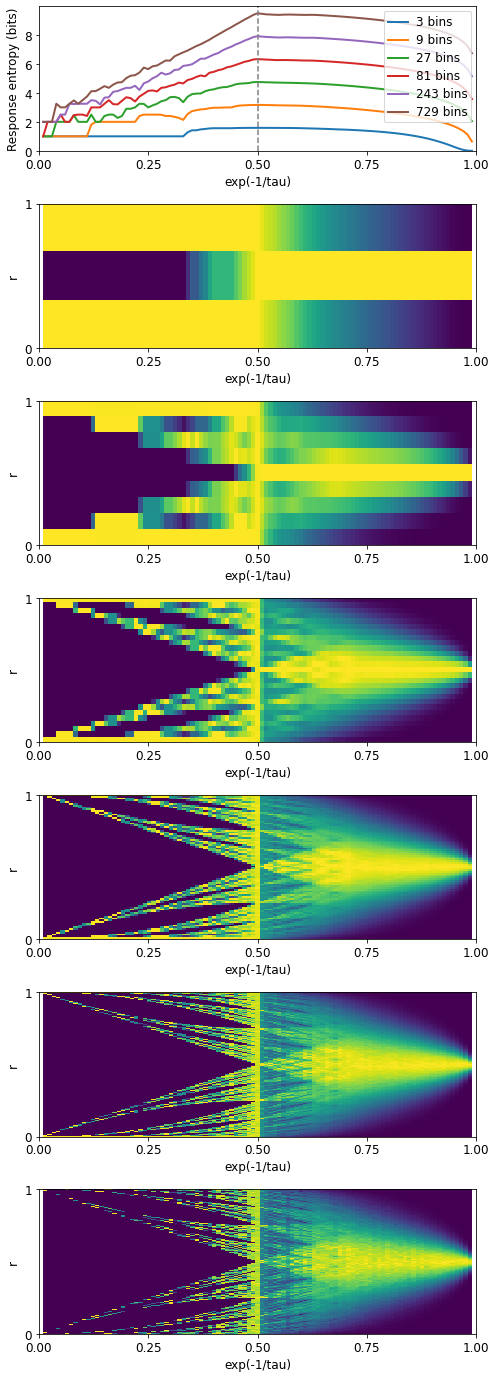

In [3]:
# plot entropy vs bin size and tau
fig, axs = plt.subplots(1+len(nbin), 1, figsize=(7, 2.75*(1+len(nbin))), tight_layout=True)
axs[0].plot(a, h.T, lw=2)
axs[0].axvline(.5, color='gray', ls='--')
axs[0].set_xlim(0, 1)
axs[0].set_ylim(bottom=0)
axs[0].set_xticks(np.linspace(0, 1, 5))
axs[0].set_xlabel('exp(-1/tau)')
axs[0].set_ylabel('Response entropy (bits)')
axs[0].legend([f'{nbin_} bins' for nbin_ in nbin], loc='upper right')

# single response distributions vs tau for diff bin sizes
for nbin_, ct_plt, ax in zip(nbin, cts_plt, axs[1:]):
    ax.matshow(ct_plt, origin='lower', interpolation='nearest', extent=[a[0], a[-1], 0, 1])
    ax.set_aspect('auto')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks(np.linspace(0, 1, 5))
    ax.xaxis.tick_bottom()
    ax.set_xlabel('exp(-1/tau)')
    ax.set_ylabel('r')
set_font_size(axs, 12)

# Example 2D response histograms

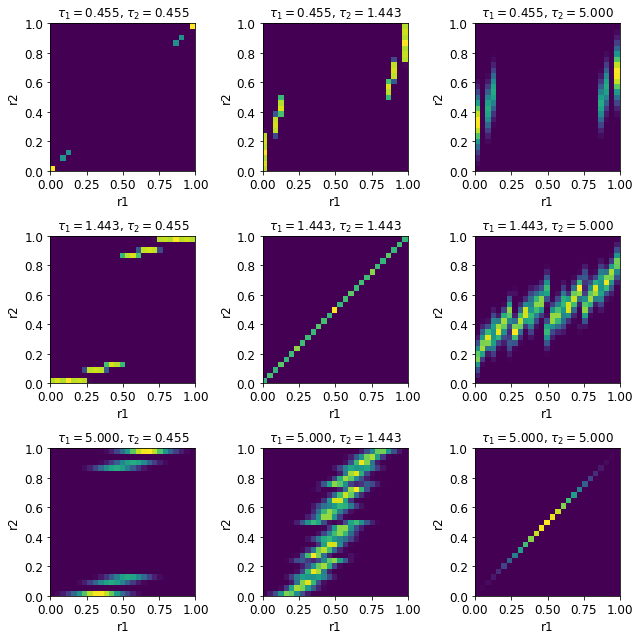

In [4]:
tau_xpl = [1/np.log(9), 1/np.log(2), 5]

fig, axs = plt.subplots(3, 3, figsize=(9, 9), tight_layout=True)

for tau_0, ax_row in zip(tau_xpl, axs):
    for tau_1, ax in zip(tau_xpl, ax_row):
        ca_0 = np.sum(tau <= tau_0)
        ca_1 = np.sum(tau <= tau_1)
    
        ax.hist2d(r[:, ca_0], r[:, ca_1], bins=np.linspace(0, 1, 28))
        ax.set_xlabel('r1')
        ax.set_ylabel('r2')
        ax.set_title(r'$\tau_1 = $' + f'{tau_0:.3f}, ' + r'$\tau_2 = $' + f'{tau_1:.3f}')
        
set_font_size(axs, 12)

In [5]:
import sys

try:
    temp = np.load(f'h2_{len(a)}_a.npy', allow_pickle=True)[0]
    h2d = temp['h2d']
    nbin = temp['nbin']
    a = temp['a']
except:
    pass

    h2d = np.nan * np.zeros((len(nbin), len(a), len(a)))

    for cnbin, nbin_ in enumerate(nbin):
        print(nbin_)
        bins = np.linspace(0, 1, nbin_+1)
        for ca_0, a_0 in enumerate(a):
            sys.stdout.write('.')
            for ca_1, a_1 in enumerate(a):
                r_0, r_1 = r[:, [ca_0, ca_1]].T

                cts = np.histogram2d(r_0, r_1, bins=bins)[0].flatten()
                h2d[cnbin, ca_0, ca_1] = stats.entropy(cts.flatten(), base=2)

3
...................................................................................................9
...................................................................................................27
...................................................................................................81
...................................................................................................243
...................................................................................................729
...................................................................................................

In [6]:
np.save(f'h2_{len(a)}_a.npy', np.array([{'h2d': h2d, 'nbin': nbin, 'a': a}]))

In [7]:
def argmax_nd(arr):
    return np.unravel_index(arr.argmax(), arr.shape)

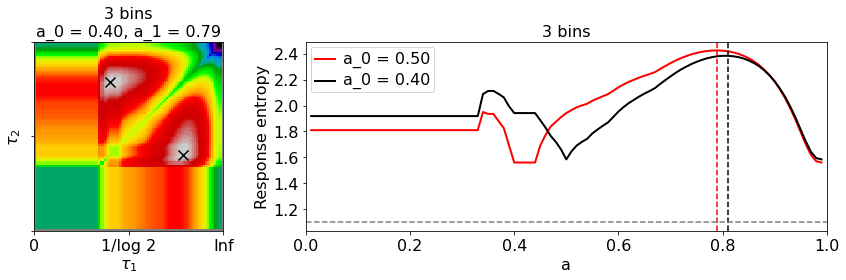

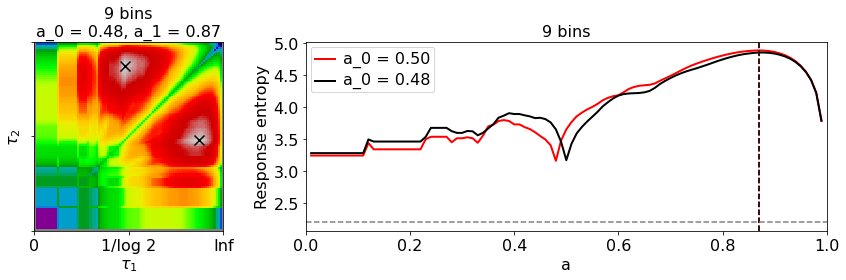

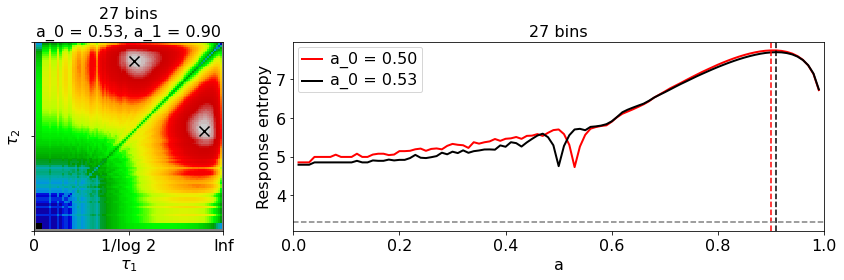

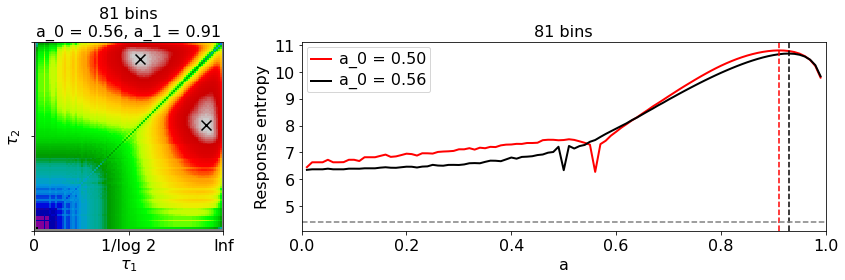

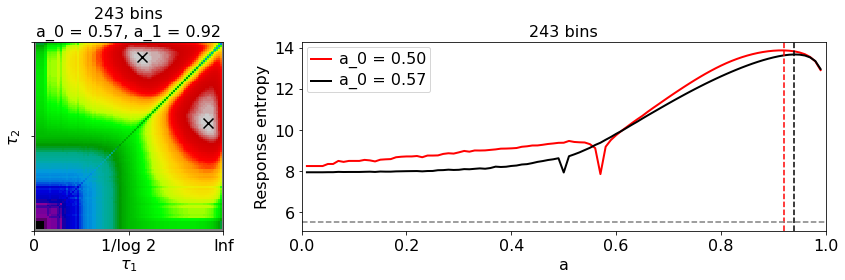

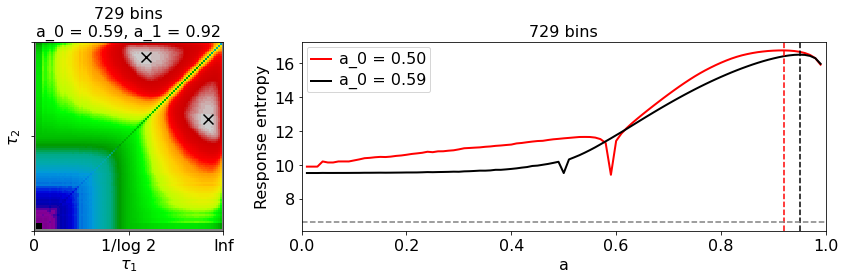

In [8]:
import matplotlib.gridspec as gridspec
a_0_bests = []
a_1_bests = []
a_1_bests_greedy = []

ia_0_bests = []
ia_1_bests = []
ia_1_bests_greedy = []

for nbin_, h2d_ in zip(nbin, h2d):
    fig = plt.figure(figsize=(12, 4), tight_layout=True)
    gs = gridspec.GridSpec(1, 3)
    axs = np.array([fig.add_subplot(gs[0]), fig.add_subplot(gs[1:])])
    
    ia_0_best, ia_1_best = sorted(list(argmax_nd(h2d_)))
    a_0_best, a_1_best = a[[ia_0_best, ia_1_best]]
    
    ia_1_best_greedy = h2d_[:, np.sum(a < .5)].argmax()
    a_1_best_greedy = a[ia_1_best_greedy]
    
    axs[0].matshow(h2d_, origin='lower', extent=[a[0], a[-1], a[0], a[-1]], cmap='nipy_spectral')
    axs[0].scatter(a_0_best, a_1_best, c='k', marker='x', s=100, zorder=10)
    axs[0].scatter(a_1_best, a_0_best, c='k', marker='x', s=100, zorder=10)
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(0, 1)
    axs[0].set_xticks([0, .5, 1])
    axs[0].set_yticks([0, .5, 1])
    axs[0].xaxis.tick_bottom()
    axs[0].set_xlabel(r'$\tau_1$')
    axs[0].set_ylabel(r'$\tau_2$')
    axs[0].set_xticklabels([0, '1/log 2', 'Inf'])
    axs[0].set_yticklabels(['', '', ''])
    axs[0].set_title(f'{nbin_} bins\na_0 = {a_0_best:.2f}, a_1 = {a_1_best:.2f}')
    axs[0].set_facecolor('gray')
    
    a_0_bests.append(a_0_best)
    a_1_bests.append(a_1_best)
    a_1_bests_greedy.append(a_1_best_greedy)
    
    ia_0_bests.append(ia_0_best)
    ia_1_bests.append(ia_1_best)
    ia_1_bests_greedy.append(ia_1_best_greedy)
    
    axs[1].plot(a, h2d_[:, np.sum(a < a_0_best)], c='r', lw=2)
    axs[1].plot(a, h2d_[:, np.sum(a < .5)], c='k', lw=2)
    axs[1].legend([f'a_0 = {a_0:.2f}' for a_0 in [.5, a_0_best]])
    
    axs[1].axvline(a_1_best, c='r', ls='--')
    axs[1].axvline(a_1_best_greedy, c='k', ls='--')
   
    axs[1].set_xlim(0, 1)
        
    axs[1].axhline(np.log(nbin_), color='gray', ls='--')
    axs[1].set_xlabel('a')
    axs[1].set_ylabel('Response entropy')
    axs[1].set_title(f'{nbin_} bins')
    
    set_font_size(axs, 16)

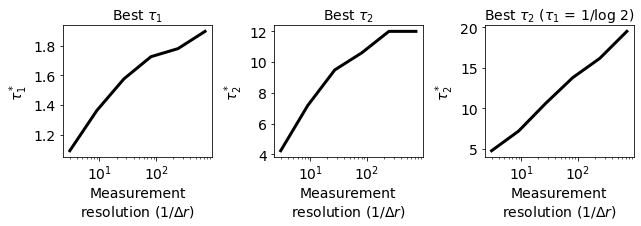

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3.25), tight_layout=True)
axs[0].semilogx(nbin, -1/np.log(a_0_bests), c='k', lw=3)
axs[0].set_title(r'Best $\tau_1$')
axs[0].set_ylabel(r'$\tau_1^*$')
axs[1].semilogx(nbin, -1/np.log(a_1_bests), c='k', lw=3)
axs[1].set_ylabel(r'$\tau_2^*$')
axs[1].set_title(r'Best $\tau_2$')
axs[2].semilogx(nbin, -1/np.log(a_1_bests_greedy), c='k', lw=3)
axs[2].set_ylabel(r'$\tau_2^*$')
axs[2].set_title(r'Best $\tau_2$ ($\tau_1$ = 1/log 2)')

for ax in axs:
    ax.set_xlabel('Measurement\n' + r'resolution ($1/\Delta r$)')

set_font_size(axs, 14)

# Continue greedy search for next best $\tau$'s

In [10]:
print(nbin)
print(ia_1_bests_greedy)
print(a[ia_1_bests_greedy])
print(tau[ia_1_bests_greedy])

[3, 9, 27, 81, 243, 729]
[80, 86, 90, 92, 93, 94]
[0.81 0.87 0.91 0.93 0.94 0.95]
[ 4.74561079  7.18070627 10.60325305 13.77966726 16.16151071 19.49572575]


In [11]:
ia_bests_greedy_all = [[np.sum(a < .5)] for nbin_ in nbin]
hs_greedy_all = [[np.log2(nbin_)] for nbin_ in nbin]

nstep = 8  # how many next taus to greedily estimate

for cnbin_, nbin_ in enumerate(nbin):  # loop over bin size/resolution
    print(f'{nbin_} bins')
    bins = np.linspace(0, 1, nbin_+1)
    
    for step in range(1, nstep+1):  # loop over greedy steps
        sys.stdout.write('.')
        hs = np.nan * np.zeros(len(a))
        
        ia_bests_greedy = ia_bests_greedy_all[cnbin_]  # current sequence of best a's
        
        for ia_ in range(len(a)):  # loop over a (as index)
            
            r_a = r[:, ia_bests_greedy + [ia_]]
            
            cts = hist_nd(r_a, bins)[0]
            hs[ia_] = stats.entropy(cts/np.sum(cts), base=2)

        ia_bests_greedy_all[cnbin_].append(np.argmax(hs))
        hs_greedy_all[cnbin_].append(np.max(hs))
        
    print('')

3 bins
........
9 bins
........
27 bins
........
81 bins
........
243 bins
........
729 bins
........


In [12]:
a_bests_greedy_all = []
tau_bests_greedy_all = []

for ia_bests_greedy in ia_bests_greedy_all:
    a_bests_greedy = a[ia_bests_greedy]
    a_bests_greedy_all.append(a_bests_greedy)
    
    tau_bests_greedy = tau[ia_bests_greedy]
    tau_bests_greedy_all.append(tau_bests_greedy)

In [13]:
tau_bests_greedy_all[0]

array([ 1.44269504,  4.74561079,  0.95254232,  2.80367325,  8.58120014,
        1.06201246,  2.02307797, 13.77966726,  3.64382559])

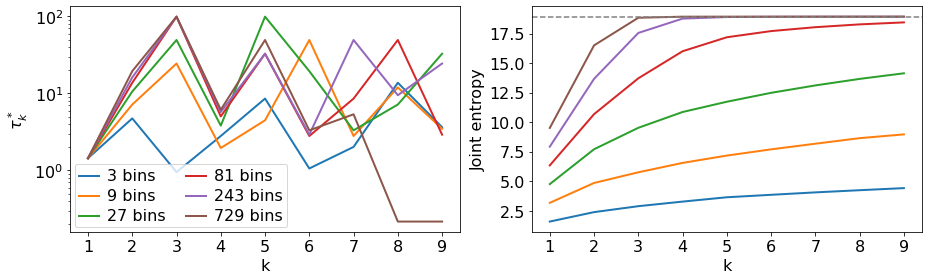

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(13, 4), tight_layout=True)
for nbin_, tau_bests_greedy, hs_greedy in zip(nbin, tau_bests_greedy_all, hs_greedy_all):
    axs[0].semilogy(1 + np.arange(nstep + 1), tau_bests_greedy, lw=2)
    axs[1].plot(1 + np.arange(nstep + 1), hs_greedy, lw=2)
    
axs[1].axhline(np.log2(len(r)), color='gray', ls='--')
    
axs[0].set_ylabel(r'$\tau_k^*$')
axs[0].legend([f'{nbin_} bins' for nbin_ in nbin], ncol=2)
axs[1].set_ylabel('Joint entropy')

for ax in axs:
    ax.set_xticks(1 + np.arange(nstep + 1))
    ax.set_xlabel('k')
    
set_font_size(axs, 16)

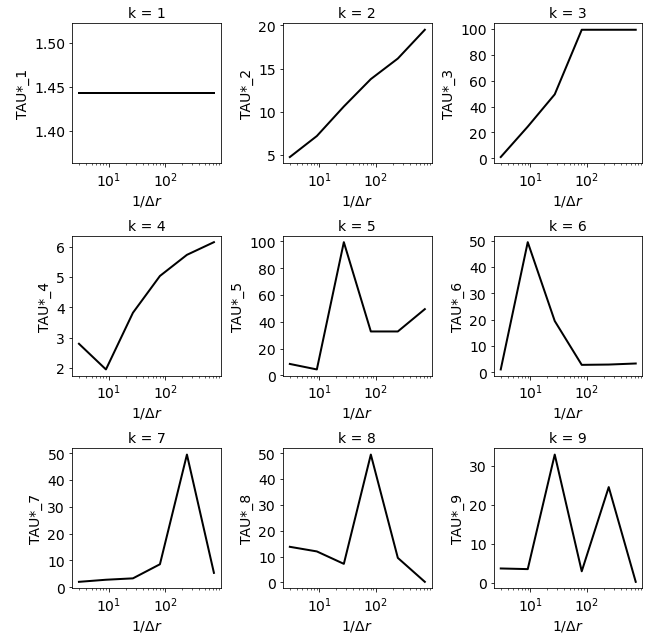

In [15]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9), tight_layout=True)

for k, ax in enumerate(axs.flatten()):
    ax.semilogx(nbin, [tau_bests_greedy[k] for tau_bests_greedy in tau_bests_greedy_all], lw=2, c='k')
    ax.set_xlabel(r'$1/\Delta r$')
    ax.set_ylabel(f'TAU*_{k+1}')
    ax.set_title(f'k = {k+1}')
    
set_font_size(axs, 14)

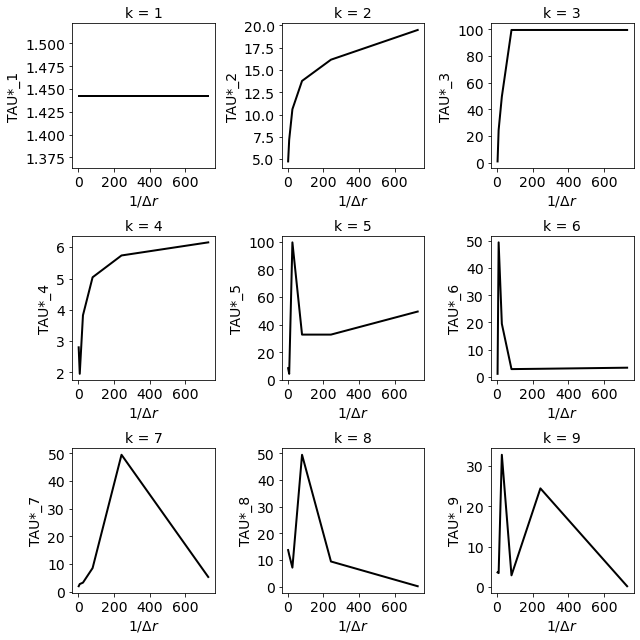

In [16]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9), tight_layout=True)

for k, ax in enumerate(axs.flatten()):
    ax.plot(nbin, [tau_bests_greedy[k] for tau_bests_greedy in tau_bests_greedy_all], lw=2, c='k')
    ax.set_xlabel(r'$1/\Delta r$')
    ax.set_ylabel(f'TAU*_{k+1}')
    ax.set_title(f'k = {k+1}')
    
set_font_size(axs, 14)